<a href="https://colab.research.google.com/github/rajeshsahu09/CS69002_9A_18CS60R19/blob/master/DL_Assign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Review Sentiment Analysis

# Run on **GPU**



### Import Header Files

In [0]:
import torch
import pandas as pd
import numpy as np
import io

### Load the Dataset and Visualise

In [0]:
# from google.colab import files
# uploaded = files.upload()

# import io
# df_train = pd.read_csv(io.StringIO(uploaded['Train_20K.csv'].decode('utf-8')), sep='\t')
# df_train.head()
url = "https://raw.githubusercontent.com/binny-mathew/IITKGP_CS69002_Spring_2019/master/Dataset/Train_20K.csv"
df = pd.read_csv(url, sep='\t')

In [140]:
df.shape

(17999, 2)

In [0]:
df_1 = df[df['label']==1]
df_0 = df[df['label']==0]

range_1 = int(0.8*len(df_1))
range_2 = int(0.8*len(df_0))

np.random.seed(42) # fix the seed value
df_1 = df_1.iloc[np.random.permutation(len(df_1))] # shuffled the data set of label==1
df_0 = df_0.iloc[np.random.permutation(len(df_0))] # shuffled the data set of label==0

temp_1_train = df_1.iloc[:range_1]
temp_2_train = df_0.iloc[:range_2]
df_train = pd.concat([temp_1_train, temp_2_train])

temp_1_val = df_1.iloc[range_1:]
temp_2_val = df_0.iloc[range_2:]
df_val = pd.concat([temp_1_val, temp_2_val])


In [144]:
len(df_train), len(df_val)

(14399, 3600)

In [146]:
print('Number of Negative movie reviews', len(df_train[df_train['label']==0]))
print('Number of Positive movie reviews', len(df_train[df_train['label']==1]))
print('Number of movie reviews', len(df_train['label']))

Number of Negative movie reviews 7195
Number of Positive movie reviews 7204
Number of movie reviews 14399


In [0]:
# from google.colab import files
# uploaded = files.upload()

# import io
# df_test = pd.read_csv(io.StringIO(uploaded['Test_5K.csv'].decode('utf-8')), sep='\t')
# df_test.head()
url = "https://raw.githubusercontent.com/binny-mathew/IITKGP_CS69002_Spring_2019/master/Dataset/Test_5K.csv"
df_test = pd.read_csv(url, sep='\t')

## Data pre-processing

### Get Train Data

In [0]:
train_raw_text_reviews = df_train['text'].astype(str).tolist()
train_text_labels = df_train['label'].astype(int).tolist()

###Get Validation Data

In [0]:
val_raw_text_reviews = df_val['text'].astype(str).tolist()
val_text_labels = df_val['label'].astype(int).tolist()

###Get Test Data

In [0]:
test_raw_text_reviews = df_test['text'].astype(str).tolist()
test_text_labels = df_test['label'].astype(int).tolist()

#### Cleaning the raw input data

In [159]:
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

# Finding stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def preprocess_document(doc):
    # negative sense should not be eleminated + some short representation
    CONTRACTIONS = {"mayn't":"may not", "can't":"can not", "won't":"will not", "isn't":"is not", "amn't":"am not",\
                  "aren't":"are not", "wasn't":"was not", "weren't":"were not", "couldn't":"could not", \
                  "wouldn't":"would not", "don't":"do not", "doesn't":"does not",\
                  "i'll":"i will", "you'll":"you will", "they'll":"they will",\
                  "may've":"may have", "can've":"can have", "will've":"will have", "you've":"you have", \
                  "could've":"could have", "would've":"would have", "you've":"you have", "they":"they have",\
                  "i've":"i have", "you've":"you have", "we've":"we have", "there's":"there is", "i'm":"i am",\
                  "it's":"it is", "what's":"what is", "where's":"where is", "how's":"how is", "i'd":"i had"}
    punctuation = string.punctuation + "\n\n"
    punc_replace = ''.join([' ' for s in punctuation]) # required for replacing punctuation with null ('')
    doc_clean = doc.replace('-', ' ') # replace - with null str
    doc_clean = (doc_clean.encode('ascii', 'ignore')).decode("utf-8")
    doc_clean = doc_clean.replace('<br />', '') # replace <br /> with ''
    doc_clean = doc_clean.replace("’", "'") # replace <br /> with null str
    doc_clean = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in doc_clean.split(' ')] # replacing some common short forms
    doc_clean = " ".join(doc_clean) # list to sentence of strings
    doc_clean = re.sub(r'\W +', ' ', doc_clean) # except [a-zA-Z0-9_]
    doc_clean = re.sub(r'\d+', ' ', doc_clean) # remove numbers [0-9]
    trans_table = str.maketrans(punctuation, punc_replace); # replace punctuations with ' '
    doc_clean = ' '.join([word.translate(trans_table) for word in doc_clean.split(' ')])
    doc_clean = doc_clean.split(' ');
    doc_clean = [word for word in doc_clean if len(word) > 0];
    # removing the stopwords from a sentence
    doc_clean = [word for word in doc_clean if not word in stop_words and word != 'not' and word != 'no']
    return doc_clean;

In [161]:
train_text_reviews = [preprocess_document(review.lower()) for review in train_raw_text_reviews]
print (train_text_reviews[len(train_text_reviews)-2])
print (train_text_labels[len(train_text_labels)-2])

['really', 'believe', 'spent', 'movie', 'huge', 'zombie', 'fanatic', 'thought', 'movie', 'could', 'bad', 'zombies', 'right', 'wrong', 'honest', 'movie', 'moments', 'thought', 'cool', 'guy', 'got', 'head', 'ripped', 'overall', 'think', 'would', 'enjoyable', 'slide', 'razorblade', 'slide', 'bare', 'nutsack', 'vat', 'vinegar', 'watch', 'movie', 'movie', 'could', 'better', 'could', 'see', 'boob', 'watch', 'trailers', 'movies', 'produced', 'company', 'see', 'buyer', 'beware', 'unless', 'masochism']
0


In [162]:
val_text_reviews = [preprocess_document(review.lower()) for review in val_raw_text_reviews]
print (val_text_reviews[len(val_text_reviews)-2])
print (val_text_labels[len(val_text_labels)-2])

['piece', 'crap', 'funny', 'whole', 'movie', 'nothing', 'ever', 'happens', 'almost', 'fell', 'asleep', 'case', 'happens', 'movie', 'rally', 'bad', 'get', 'awful', 'fooled', 'like', 'first', 'review', 'waste', 'money', 'time', 'spend', 'stuff', 'point', 'finished', 'review', 'fill', 'least', 'ten', 'lines', 'text', 'go', 'ctrl', 'c', 'ctrl', 'v', 'piece', 'crap', 'funny', 'whole', 'movie', 'nothing', 'ever', 'happens', 'almost', 'fell', 'asleep', 'case', 'happens', 'movie', 'rally', 'bad', 'get', 'awful', 'fooled', 'like', 'first', 'review', 'waste', 'money', 'time', 'spend', 'stuff', 'piece', 'crap', 'funny', 'whole', 'movie', 'nothing', 'ever', 'happens', 'almost', 'fell', 'asleep', 'case', 'happens', 'movie', 'rally', 'bad', 'get', 'awful', 'fooled', 'like', 'first', 'review', 'waste', 'money', 'time', 'spend', 'stuff']
0


In [163]:
test_text_reviews = [preprocess_document(review.lower()) for review in test_raw_text_reviews]
print (test_text_reviews[len(test_text_reviews)-2])
print (test_text_labels[len(test_text_labels)-2])

['shining', 'know', 'weird', 'movie', 'movie', 'everyone', 'people', 'claim', 'like', 'horror', 'films', 'always', 'say', 'shining', 'terrific', 'film', 'stanley', 'kubrick', 'classic', 'vision', 'stephen', 'king', 'horror', 'tale', 'madness', 'blood', 'incredible', 'film', 'wither', 'seen', 'heard', 'know', 'lines', 'know', 'classic', 'images', 'could', 'forget', 'jack', 'johnny', 'could', 'forget', 'work', 'play', 'make', 'jack', 'dull', 'boy', 'could', 'forget', 'chilling', 'ending', 'film', 'unforgettable', 'honestly', 'opinion', 'kubrick', 'best', 'work', 'know', 'lot', 'argument', 'department', 'lot', 'people', 'say', 'space', 'odyssey', 'clockwork', 'orange', 'even', 'dr', 'strangelove', 'film', 'pioneered', 'film', 'making', 'shining', 'perfected', 'tale', 'isolation', 'madness', 'terrifying', 'images', 'ultimate', 'ghost', 'story', 'crawl', 'underneath', 'skin', 'jack', 'torrance', 'jack', 'son', 'danny', 'jack', 'wife', 'wendy', 'arrive', 'overlook', 'hotel', 'closing', 'day'

In [164]:
import gc
gc.collect()

116

###Creating Tokens and Types

In [18]:
# Fetching the tokens (all words in a doc) and types(unique words in a doc) in the document
types = ()
tokens = []
for row in train_text_reviews+val_text_reviews+test_text_reviews:
    tokens += [words for words in row]
types = set(tokens)

VOCAB_SIZE, TOKEN_SIZE = len(types), len(tokens)
VOCAB_SIZE, TOKEN_SIZE

(72098, 2809504)

In [19]:
word_to_ix = {x:i for i, x in enumerate(types)}
ix_to_word = [x for i, x in enumerate(types)]

ix_to_word[word_to_ix['kick']]=='kick', word_to_ix['kick'], len(ix_to_word)

(True, 28183, 72098)

In [20]:
gc.collect()

164

## PyTorch

In [21]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable # Automatic gradients are calculated and back-propagated through the computational graph

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

##Model Definition for the BOWClassifier

In [0]:
class BOWClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BOWClassifier, self).__init__()
        SEED = 42
        torch.manual_seed(SEED)
        torch.cuda.manual_seed(SEED)
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, hidden_size) # initialises weights and biases i2h
        self.h2o = nn.Linear(hidden_size, output_size) # initialises weights and biases h2o
#         self.i2o = nn.Linear(input_size, output_size) # initialises weights and biases i2o
         
    def forward(self, x):
        x = torch.relu(self.i2h(x)) # relu activation @ hidden layer
        x = torch.sigmoid(self.h2o(x)) # sigmoid activation @ output layer
        return x

### Initialise Parameter and Model

In [33]:
num_of_input = VOCAB_SIZE # Bag word restriction has to be equal to vocabulary
num_of_hidden = 50 # vary this for assignment
num_of_output = 1 # binary sentiment classes (+ve, -ve)

bow = BOWClassifier(num_of_input, num_of_hidden, num_of_output).to('cuda:0') # initialises weights and biases
bow.i2h, bow.h2o # desc network

# bow.i2o

(Linear(in_features=72098, out_features=50, bias=True),
 Linear(in_features=50, out_features=1, bias=True))

#### visualise the parameter

In [34]:
for param in bow.parameters(): # desc the parameter value
    print(param,param.size())

Parameter containing:
tensor([[ 0.0028,  0.0031, -0.0009,  ...,  0.0013,  0.0002,  0.0032],
        [-0.0035, -0.0032, -0.0017,  ...,  0.0025, -0.0011, -0.0002],
        [ 0.0010,  0.0022, -0.0014,  ...,  0.0005, -0.0004,  0.0025],
        ...,
        [ 0.0018,  0.0020,  0.0019,  ...,  0.0023, -0.0005, -0.0022],
        [-0.0004, -0.0036, -0.0005,  ...,  0.0002,  0.0009,  0.0002],
        [-0.0037,  0.0010, -0.0030,  ..., -0.0003, -0.0001, -0.0032]],
       device='cuda:0', requires_grad=True) torch.Size([50, 72098])
Parameter containing:
tensor([ 0.0011,  0.0004,  0.0031, -0.0034, -0.0035, -0.0011, -0.0032,  0.0018,
         0.0030,  0.0035,  0.0010, -0.0009, -0.0037,  0.0021,  0.0017,  0.0023,
        -0.0003,  0.0017, -0.0013,  0.0020,  0.0022, -0.0023,  0.0021,  0.0006,
         0.0027,  0.0002, -0.0031, -0.0016,  0.0030,  0.0012, -0.0007, -0.0016,
         0.0007,  0.0009,  0.0024,  0.0037,  0.0026,  0.0007,  0.0032, -0.0031,
        -0.0023, -0.0017, -0.0031, -0.0026,  0.0031, -

## Generate the BOW Vectors

In [0]:
def make_bow_vector(sentence, word_to_ix):
    # create a vector of zeros of vocab size = len(word_to_idx)
    vec = torch.zeros(len(word_to_ix)).to('cuda:0') #, device=device) # make 1D vector of len = vocab size
    for word in sentence:
        if word not in word_to_ix:            
#             raise ValueError('Word',word,' not present in the dictionary. Sorry!')
            pass
        else:
            vec[word_to_ix[word]]+=1 # count the number of occurance of same word in a sentences
            
    return vec.view(1, -1)

### Store in input sentences torch vector

In [0]:
import time

In [29]:
# store the bag of word vectors for each sentences and wraping to tensor of torch type
tic = time.time()
train_data = [Variable(make_bow_vector(instance, word_to_ix)).to('cuda:0') for instance in train_text_reviews]
num_train_data = len(train_text_reviews)


val_data = [Variable(make_bow_vector(instance, word_to_ix)).to('cuda:0') for instance in val_text_reviews]
num_val_data = len(val_text_reviews)
toc = time.time()
num_train_data, num_val_data, (toc-tic)

(17999, 499, 104.50174760818481)

### Validation Accuracy Computation

In [0]:
def evaluate_validation_accuracy(data, net):
    sum_loss = 0
    
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    for i, instance in enumerate(data):
        label = val_text_labels[i] # get the label of the corresponding instace
        label = Variable(torch.FloatTensor([label])).resize_((1,1)).to('cuda:0') # wraps a tensor for label
        
#         vec = Variable(make_bow_vector(instance, word_to_ix)).to('cuda:0') # wrap to tensor of torch type for instance
        
#         prob = net.forward(vec) # forward pass

        prob = net.forward(instance)
    
        _class = 1 if prob.item() > 0.5 else 0 # sigmoid activated
        
        loss = loss_function(prob, label) # compute the loss
        
        sum_loss += float(loss.item())
        
        if(int(label) == _class and _class == 1):
            true_positive += 1
            
        if(int(label) == _class and _class == 0):
            true_negative += 1
        
        if(_class == 1 and int(label) == 0):
            false_positive += 1
            
        if(_class == 0 and int(label) == 1):
            false_negative += 1

    precision = float(true_positive) / (true_positive + false_positive)
    recall = float(true_positive) / (true_positive + false_negative)
    f_score = float(2)*true_positive / (2*true_positive + false_positive + false_negative)
    
    return float(sum_loss)/len(data), float(100)*(true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative), precision, recall, f_score

## Define Loss function

In [0]:
epochs = 100
# define a loss function and an optimizer
loss_function = nn.BCELoss()
opt = torch.optim.SGD(bow.parameters(), lr = float(1)/epoch)#, momentum=0.9)

In [37]:
gc.collect()

8

## Train the model

In [39]:
# the training loop
total_time = 0.0
train_epoch_history = []
train_loss_history = []
val_loss_history = []

for e in range(epochs):
    tic = time.time() # start the timer
    correct = 0
    cumulative_loss = 0
    incorrect = 0
    
    for i, instance in enumerate(train_data): # train_text_reviews 
        # get the training data
        label = train_text_labels[i] # get the label of the corresponding instace
        label = Variable(torch.FloatTensor([label])).resize_((1,1)).to('cuda:0') # wraps a tensor for label
        
        bow.zero_grad() # reset the gradient for each instance
        
#         bow_vec = Variable(make_bow_vector(instance, word_to_ix)).to('cuda:0') # vector repesentation of input sentence
        
#         pred = bow.forward(bow_vec) # forward pass ==> computes predictied values (1 or 0)
        pred = bow.forward(instance)
    
        loss = loss_function(pred, label) # compute the loss
        loss.backward() # backprop the loss
        opt.step() # performs parameter updation based on the current gradient
        
        cumulative_loss += float(loss.item()) # accumulate the loss over whole training sample
        
        pred_class = 1 if pred.item() > 0.5 else 0 # as sigmoid activated
        if(int(label) == pred_class): # counting correct prediction in each epoch
            correct += 1
        
    train_epoch_history.append(e+1)
    train_loss_history.append(float(cumulative_loss)/num_train_data)
    
    val_loss, val_accuracy, p, r, f = evaluate_validation_accuracy(val_data, bow) # test val-data-set on currently trained model
    val_loss_history.append(val_loss/num_val_data)
    
    toc = time.time() # final time
    total_time += (toc-tic)
    
    print("Epoch {}/{}\n[On Training] ==> Time: {:.2f}s, Train Loss: {:.9f}, Train Accuracy: {:.2f}%".format(e+1, epochs, (toc-tic), float(cumulative_loss)/num_train_data, correct*float(100)/num_train_data))
    print("[On Validation] ==> Precision: {:.3f}, Recall: {:.3f}, F-Score: {:.3f}, Val loss: {:.9f}, Val Accuracy: {:.2f}% Total Time: {:.2f}s".format(p, r, f, val_loss, val_accuracy, total_time))

Epoch 1/100
[On Training] ==> Time: 42.28s, Train Loss: 0.490627056, Train Accuracy: 76.50%
[On Validation] ==> Precision: 0.791, Recall: 0.854, F-Score: 0.821, Val loss: 0.434530610, Val Accuracy: 81.16% Total Time: 42.28s
Epoch 2/100
[On Training] ==> Time: 42.29s, Train Loss: 0.359034021, Train Accuracy: 84.60%
[On Validation] ==> Precision: 0.858, Recall: 0.909, F-Score: 0.883, Val loss: 0.273836044, Val Accuracy: 87.78% Total Time: 84.57s
Epoch 3/100
[On Training] ==> Time: 42.27s, Train Loss: 0.309304970, Train Accuracy: 86.25%
[On Validation] ==> Precision: 0.839, Recall: 0.949, F-Score: 0.891, Val loss: 0.299580080, Val Accuracy: 88.18% Total Time: 126.85s
Epoch 4/100
[On Training] ==> Time: 42.11s, Train Loss: 0.239977344, Train Accuracy: 89.32%
[On Validation] ==> Precision: 0.890, Recall: 0.960, F-Score: 0.924, Val loss: 0.209757740, Val Accuracy: 91.98% Total Time: 168.95s
Epoch 5/100
[On Training] ==> Time: 42.06s, Train Loss: 0.208395128, Train Accuracy: 90.99%
[On Valida

In [40]:
gc.collect()

583

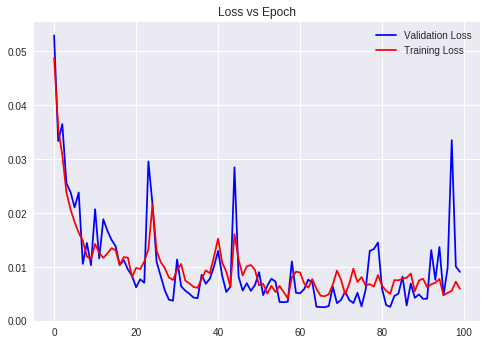

In [41]:
import matplotlib.pyplot as plt
plt.figure("Image")
plt.title("Loss vs Epoch")
val_loss_history =  [float(i)/sum(val_loss_history) for i in val_loss_history] # normalised between 0-1
train_loss_history =  [float(i)/sum(train_loss_history) for i in train_loss_history] # normalised between 0-1
plt.plot(val_loss_history, c="blue", label="Validation Loss")
plt.plot(train_loss_history, c="red", label = "Training Loss")
plt.legend()

In [0]:
data = []
data = [Variable(make_bow_vector(instance, word_to_ix)).to('cuda:0') for instance in test_text_reviews]

In [43]:
print('--- AFTER TRAINING ---')
correct = 0
tic = time.time()
for i, instance in enumerate(data):
    label = test_text_labels[i]
    pred = bow.forward(instance)
    pred_class = 1 if pred.item() > 0.5 else 0 # sigmoid activated
    
    if(int(label) == pred_class):
        correct += 1
toc = time.time()
print("Time: {}, Test Accuracy: {:.2f}%".format((toc-tic), correct*100/len(data)))

--- AFTER TRAINING ---
Time: 4.523271083831787, Test Accuracy: 85.54%


In [44]:
torch.save(bow, 'Task1A.mdl')

from google.colab import files
files.download("Task1A.mdl")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type BOWClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [1]:
from google.colab import files
temp_test = files.upload()

Saving Task1A.mdl to Task1A.mdl


In [6]:
import torch
import io
_model_ = torch.load(io.BytesIO(temp_test['Task1A.mdl']))

AttributeError: ignored